# Setup

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)
% cd 'drive/Shared drives/CS 229'

Mounted at /content/drive
/content/drive/Shared drives/CS 229


In [ ]:
# importing libraries
import statsmodels.api as sm
import pandas as pd
import numpy as np

# loading the training dataset
df = pd.read_csv('data/merged_data_2_Nov1.csv', index_col = 0)

# NB: lots of missings in full set because we have very few 2020 matches; we only do 2014-2018
df_2020 = df[df['cycle'] == 2020]
df = df[df['cycle'] < 2020]

# All PFD input vars we might consider
X_VARS_90 = [
          'wealth', 
          'income', 
          'asset', 
          'liability', 
          'unearned_income', 
          'income_earned',
          'democrat',
          'incumbent',
          'against_incum',
          'cycle_2014',
          'cycle_2016',
        ]
X_VARS_vote = [
          'wealth', 
          'income', 
          'asset', 
          'liability', 
          'unearned_income', 
          'income_earned',
          'total_ninety',
          'democrat',
          'incumbent',
          'against_incum',
          'cycle_2014',
          'cycle_2016',
        ]

def train_test_split_random_sample(df, y_var='total_ninety', X_VARS=X_VARS_90, test_proportion=0.3, seed=0):
  df_copy = df.copy()
  y_var = y_var

  from sklearn.preprocessing import scale

  test_set = df_copy.sample(frac=test_proportion, random_state=seed)
  train_set = df_copy.drop(test_set.index)

  # defining the dependent and independent variables
  Xtrain = train_set[X_VARS]
  ytrain = train_set[[y_var]]

  # defining the dependent and independent variables
  Xtest = test_set[X_VARS]
  ytest = test_set[y_var]

  return Xtrain, ytrain, Xtest, ytest

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (33,72,73,75,77,82,87,94,95,97,99,101,103) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


### Data Cleaning

In [ ]:
original = df.copy()

In [ ]:
# Drop known unmatched people
df = df[df['rid'] != 'missing']
df = df[df['rid'] != 'dupe']
df = df[df['pfd_id'] >= 10000000]

In [ ]:
df.dropna(subset=['total_ninety'], inplace=True)

In [ ]:
df = df.dropna(subset=['income'])

In [ ]:
# Create median variables:
df['liability'] = (df['max_liability'] + df['min_liability']) / 2
df['asset'] = (df['max_asset'] + df['min_asset']) / 2
df['unearned_income'] = (df['max_unearned_income'] + df['min_unearned_income']) / 2

# Create some categorical variables
df['democrat'] = (df['party'] == 100).astype(int)
df['incumbent'] = (df['Incum.Chall'] == 'I').astype(int)
df['cycle_2014'] = (df['cycle'] == 2014).astype(int)
df['cycle_2016'] = (df['cycle'] == 2016).astype(int)

has_incumbent = df.groupby(['district','cycle','party'])['incumbent'].sum()
df['incum_in_primary'] = df.apply(lambda r : False if type(r.district) != str else has_incumbent[(r.district,r.cycle,r.party)] > 0, axis=1).astype(int)
df['against_incum'] = ((df['incum_in_primary'] == 1) & (df['incumbent'] == 0)).astype(int)

In [ ]:
Xtrain, ytrain, Xtest, ytest = train_test_split_random_sample(df, test_proportion = 0.2)

In [ ]:
ytrain

,total_ninety
0,2868.86
1,194700.00
2,12235.00
3,1598.00
4,6970.00
...,...
2961,116244.97
2963,102687.17
2971,2700.00
2993,148072.79


### Data visualization (log-log scatter plots)



In [ ]:
import matplotlib.pyplot as plt


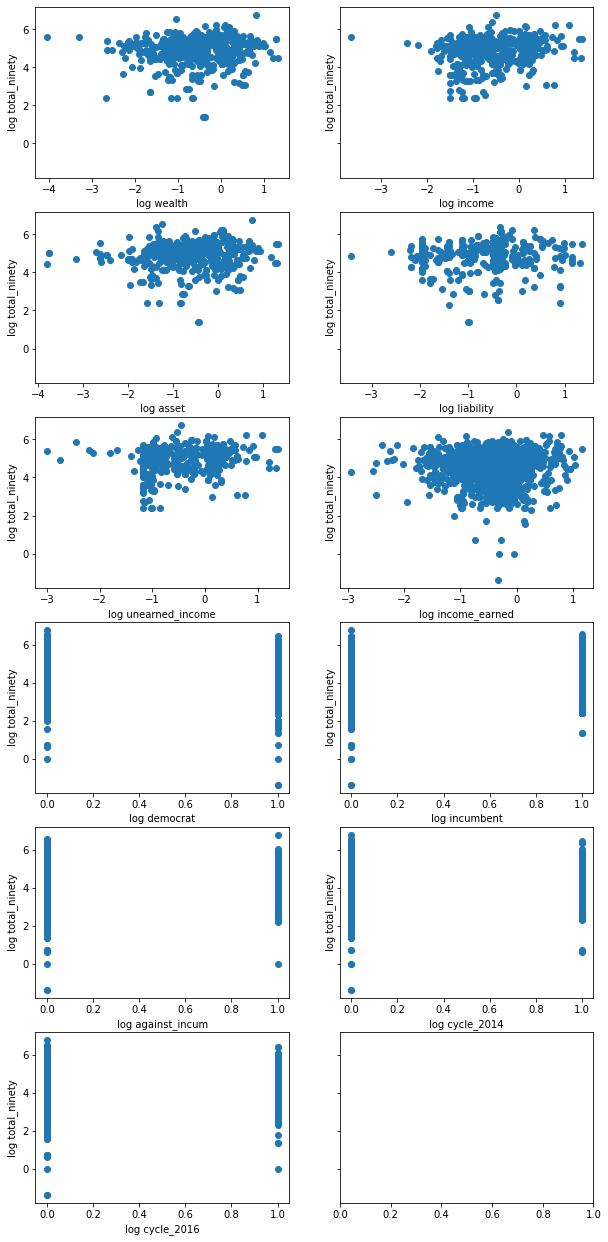

In [ ]:

fig, axes = plt.subplots(len(X_VARS_90) // 2 + len(X_VARS_90) % 2, 2, figsize=(10,len(X_VARS_90) * 2), sharey=True)
y_var = 'total_ninety'
y = ytrain[y_var].copy()
y[y == 0] = 1
y = y.apply(np.log10)

for i, x_var in enumerate(X_VARS_90):
  ax = axes[i // 2, i % 2]
  x = Xtrain[x_var].copy()
  if x.max() > 1:
    x[x == 0] = 1
    x = x.apply(np.log10)
  ax.scatter(x, y)
  ax.set_xlabel('log ' + x_var)
  ax.set_ylabel('log ' + y_var)

plt.show()

## Predict 90-day funds
Two attributes

In [ ]:
exog, endog = sm.add_constant(Xtrain[['wealth', 'income']]), ytrain

# Poisson regression
# mod = sm.GLM(endog, exog, family=sm.families.Poisson(link=sm.families.links.log()))
# res = mod.fit()
# display(res.summary())

# Guassian regression
mod = sm.GLM(endog, exog, family=sm.families.Gaussian())
res = mod.fit()
display(res.summary())

# Normal distribution + log link function
# mod = sm.GLM(endog, exog, family=sm.families.Gaussian(sm.families.links.log()))
# res = mod.fit()
# display(res.summary())

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:           total_ninety   No. Observations:                 3090
Model:                            GLM   Df Residuals:                     3087
Model Family:                 Poisson   Df Model:                            2
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                   -inf
Date:                Wed, 18 Nov 2020   Deviance:                   5.9857e+08
Time:                        19:47:15   Pearson chi2:                 1.22e+09
No. Iterations:                     9                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         11.6315    5.4e-05   2.15e+05      0.000      11.631      11.632
wealth       6.39e-09   3.08e-12   2072.401      0.000    6.38e-09     6.4e-09
income     -1.756e-08   2.84e-11   -618.452      0.000   -1.76e-08   -1.75e-08
==============================================================================
"""

In [ ]:
# performing predictions on the test datdaset
yhat = res.predict(sm.add_constant(Xtest[['wealth', 'income']]))

# comparing original and predicted values of y
print('Acutal values :', list(ytest.values))
print('Predictions :', list(yhat.values))

Acutal values : [11980.23, 188604.49, 484.25, 332130.13, 11500.0, 27735.0, 15619.62, 388806.52, 2567.9, 3250.0, 347349.0, 175933.32, 25940.0, 9075.0, 2350.0, 184296.22, 10740.0, 359198.35, 4999.51, 239586.25, 250.0, 55.0, 27735.0, 67616.95, 3950.0, 21250.0, 117418.1, 74033.77, 242585.0, 100525.0, 250.0, 19970.0, 41444.5, 21270.28, 105045.24, 490432.65, 192959.0, 72970.84, 582532.86, 185060.0, 48872.18, 106750.11, 270941.2, 88765.0, 2872.94, 136019.32, 140778.0, 102569.0, 11500.0, 559.6, 18016.95, 4500.0, 200820.0, 107850.0, 263028.1, 16542.66, 34540.52, 6101.110000000002, 119527.0, 25883.32, 267325.0, 117418.1, 62653.02, 175933.32, 90947.5, 42975.0, 6000.0, 41150.0, 138420.0, -9.0, 250.0, 308780.0, 166762.75000000006, 37650.0, 64320.0, 5662.17, 235624.58, 31047.75, 764948.14, 32994.0, 155983.85, 115723.0, 6875.0, 11250.0, 7700.0, 241031.41, 213270.0, 42321.0, 152463.44, 20350.0, 102569.0, 24618.81, 13321.76, 131712.0, 127207.78, 138554.69, 12900.0, 50.0, 5100.0, 5499.0, 78371.0, 512242

In [ ]:
from sklearn.metrics import mean_absolute_error

mean_absolute_error(list(ytest.values), list(yhat.values))

102241.58922282116

In [ ]:
def mape(actual, pred): 
    epsilon = np.finfo(np.float64).eps
    mape = np.abs(pred - actual) / np.maximum(np.abs(actual), epsilon)
    output_errors = np.average(mape, axis=0)

    return np.average(output_errors)
mape(ytest, yhat)

99.47875212332049

In [ ]:
# Guassian regression
mod = sm.GLM(endog, exog, family=sm.families.Gaussian())
res = mod.fit()
# performing predictions on the test datdaset
yhat = res.predict(sm.add_constant(Xtest[['wealth', 'income']]))
mape(ytest, yhat)

97.74934301791583

In [ ]:
# Normal distribution + log link function
mod = sm.GLM(endog, exog, family=sm.families.Gaussian(sm.families.links.log()))
res = mod.fit()
# performing predictions on the test datdaset
yhat = res.predict(sm.add_constant(Xtest[['wealth', 'income']]))
mape(ytest, yhat)

98.98443702487111

In [ ]:
!pip install eli5
import eli5
from eli5.sklearn import PermutationImportance

In [ ]:
ytrain = np.ravel(ytrain)
ytest = np.ravel(ytest)

In [ ]:
from sklearn import svm
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

def mape(actual, pred): 
    epsilon = np.finfo(np.float64).eps
    mape = np.abs(pred - actual) / np.maximum(np.abs(actual), epsilon)
    output_errors = np.average(mape, axis=0)

    return np.average(output_errors)

regr = make_pipeline(StandardScaler(), svm.SVR(C=10e7, epsilon=0.2, gamma=1000))
svr = regr.fit(Xtrain[['wealth', 'income', 'liability', 'asset', 'unearned_income', 'income_earned']], ytrain)
ypred = regr.predict(Xtest[['wealth', 'income', 'liability', 'asset', 'unearned_income', 'income_earned']])
mape(ytest, ypred)

In [ ]:
print('Acutal values :', list(ytest))
print('Predictions :', list(ypred))

In [ ]:
perm = PermutationImportance(svr, random_state=1).fit(Xtest[['wealth', 'income', 'liability', 'asset', 'unearned_income', 'income_earned']], ytest)
eli5.show_weights(perm, feature_names = Xtest[['wealth', 'income', 'liability', 'asset', 'unearned_income', 'income_earned']].columns.tolist())

### All Attributes

In [ ]:
exog, endog = sm.add_constant(Xtrain), ytrain

# Poisson regression
# mod = sm.GLM(endog, exog, family=sm.families.Poisson(link=sm.families.links.log()))
# res = mod.fit()
# display(res.summary())

# Guassian regression
# mod = sm.GLM(endog, exog, family=sm.families.Gaussian())
# res = mod.fit()
# display(res.summary())

# Normal distribution + log link function
mod = sm.GLM(endog, exog, family=sm.families.Gaussian(sm.families.links.log()))
res = mod.fit()
# performing predictions on the test datdaset


In [ ]:
# performing predictions on the test datdaset
yhat = res.predict(sm.add_constant(Xtest))

In [ ]:
from sklearn.metrics import mean_absolute_error

mean_absolute_error(list(ytest.values), list(yhat.values))

95291.33939488127

In [ ]:
def mape(actual, pred): 
    epsilon = np.finfo(np.float64).eps
    mape = np.abs(pred - actual) / np.maximum(np.abs(actual), epsilon)
    output_errors = np.average(mape, axis=0)

    return np.average(output_errors)
mape(ytest, yhat)

40.64673388404003

### SVM Regression

In [ ]:
ytrain = np.ravel(ytrain)
ytest = np.ravel(ytest)

In [ ]:
from sklearn import svm
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

def mape(actual, pred): 
    epsilon = np.finfo(np.float64).eps
    mape = np.abs(pred - actual) / np.maximum(np.abs(actual), epsilon)
    output_errors = np.average(mape, axis=0)

    return np.average(output_errors)

regr = make_pipeline(StandardScaler(), svm.SVR(kernel='linear', C=10e7, epsilon=0.2, gamma='scale'))
svr = regr.fit(Xtrain, ytrain)
ypred = regr.predict(Xtest)
mape(ytest, ypred)

/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


15.243046442855091

In [ ]:
print('Acutal values :', list(ytest))
print('Predictions :', list(ypred))

Acutal values : [11980.23, 188604.49, 484.25, 332130.13, 11500.0, 27735.0, 15619.62, 388806.52, 2567.9, 3250.0, 347349.0, 175933.32, 25940.0, 9075.0, 2350.0, 184296.22, 10740.0, 359198.35, 4999.51, 239586.25, 250.0, 55.0, 27735.0, 67616.95, 3950.0, 21250.0, 117418.1, 74033.77, 242585.0, 100525.0, 250.0, 19970.0, 41444.5, 21270.28, 105045.24, 490432.65, 192959.0, 72970.84, 582532.86, 185060.0, 48872.18, 106750.11, 270941.2, 88765.0, 2872.94, 136019.32, 140778.0, 102569.0, 11500.0, 559.6, 18016.95, 4500.0, 200820.0, 107850.0, 263028.1, 16542.66, 34540.52, 6101.110000000002, 119527.0, 25883.32, 267325.0, 117418.1, 62653.02, 175933.32, 90947.5, 42975.0, 6000.0, 41150.0, 138420.0, -9.0, 250.0, 308780.0, 166762.75000000006, 37650.0, 64320.0, 5662.17, 235624.58, 31047.75, 764948.14, 32994.0, 155983.85, 115723.0, 6875.0, 11250.0, 7700.0, 241031.41, 213270.0, 42321.0, 152463.44, 20350.0, 102569.0, 24618.81, 13321.76, 131712.0, 127207.78, 138554.69, 12900.0, 50.0, 5100.0, 5499.0, 78371.0, 512242

In [ ]:
perm = PermutationImportance(svr, random_state=1).fit(Xtest, ytest)
eli5.show_weights(perm, feature_names = Xtest.columns.tolist())

Weight,Feature
0.3309 ± 0.0822,income_earned
0.3104 ± 0.1759,liability
0.2525 ± 0.0935,democrat
0.2239 ± 0.0299,incumbent
0.1695 ± 0.1182,cycle_2016
0.0517 ± 0.1156,against_incum
0.0461 ± 0.1113,wealth
0.0104 ± 0.1100,cycle_2014
-0.0270 ± 0.0971,unearned_income
-0.0424 ± 0.0997,income


In [ ]:
regr = make_pipeline(StandardScaler(), svm.SVR(C=10e7, epsilon=0.2, gamma='scale'))
svr = regr.fit(Xtrain[['wealth', 'income']], ytrain)
ypred = regr.predict(Xtest[['wealth', 'income']])
mape(ytest, ypred)

36.944615920143775

In [ ]:
perm = PermutationImportance(svr, random_state=1).fit(Xtest[['wealth', 'income']], ytest)
eli5.show_weights(perm, feature_names = Xtest[['wealth', 'income']].columns.tolist())

Weight,Feature
-0.0267 ± 0.0341,wealth
-0.0684 ± 0.0115,income


In [ ]:
from sklearn.linear_model import ElasticNet

regr = ElasticNet(l1_ratio=1, random_state=0)
enet = regr.fit(Xtrain, ytrain)
ypred = regr.predict(Xtest)
mape(ytest, ypred)

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 67982263444801.97, tolerance: 16167082133.34628
  positive)


64.08379574371574

# Predict vote share

In [ ]:
df_vs = pd.read_csv('data/merged_data_3_Nov6.csv', index_col = 0)

In [ ]:
df_vs.head()

,pfd_id,cycle,rid,file,min_liability,max_liability,min_asset,max_asset,min_unearned_income,max_unearned_income,income_earned,min_wealth,max_wealth,wealth,income,election,fecyear,Cand.ID,FEC.ID,NID,bonica.rid,bonica.cid,name,lname,ffname,fname,mname,nname,title,suffix,party,state,seat,district,Incum.Chall,recipient.cfscore,contributor.cfscore,recipient.cfscore.dyn,dwnom1,dwnom2,...,comm.cost.for,comm.cost.against,party.coord.exp,party.ind.exp.against,total.receipts,total.indiv.contrib,total.pac.contribs,ran.primary,ran.general,p.elec.stat,s.elec.stat,r.elec.stat,gen.elec.stat,gen.elect.pct,winner,district.partisanship,district.pres.vs,candStatus,recipient.type,igcat,comtype,nimsp.party,nimsp.candidate.ICO.code,nimsp.district,nimsp.office,nimsp.candidate.status,before.switch.ICPSR,after.switch.ICPSR,party.orig,total_primary,campaign_start,campaign_ninety,total_ninety,votes_primary,pct_primary,votes_runoff,pct_runoff,votes_general,pct_general,won_general
0,10000005.0,2014.0,cand143294,10000005,0.0,0.0,19008.0,113000.0,3.0,600.0,7254.40,19008.0,113000.0,66004.0,7555.90,fd2014,2014.0,H4IL16020,C00553826,NH4IL16020,cand143294,NaN,"HALE JR, DAVID JERRY",hale,david jerry,david,jerry,NaN,NaN,jr,200.0,IL,federal:house,IL16,C,1.563940,NaN,1.530,NaN,NaN,...,0.0,0.0,0.0,0.0,10082.61,5898.25,0.00,1.0,1.0,L,NaN,NaN,NaN,NaN,NaN,0.189148,0.510,C,cand,NaN,H,NaN,NaN,NaN,NaN,NaN,NaN,NaN,200.0,6193.31,2013-09-22,2013-12-21,2868.86,15558,0.215631,NaN,NaN,NaN,NaN,NaN
1,10000007.0,2014.0,cand133871,10000007,0.0,0.0,399059.0,1639000.0,12944.0,45222.0,42647.10,399059.0,1639000.0,1019029.5,71730.10,fd2014,2014.0,H4PA08108,C00543611,N00035339,cand133871,3.138665e+10,"STROUSE, KEVIN",strouse,kevin,kevin,NaN,NaN,NaN,NaN,100.0,PA,federal:house,PA08,C,-1.253776,-1.285508,-1.104,NaN,NaN,...,0.0,0.0,0.0,0.0,1346514.37,813372.65,190695.38,1.0,1.0,W,NaN,NaN,NaN,NaN,NaN,-0.077540,0.535,C,cand,NaN,H,NaN,NaN,NaN,NaN,NaN,NaN,NaN,100.0,680760.64,2013-04-01,2013-06-30,194700.00,18440,0.511327,NaN,NaN,84767,0.380979,NaN
2,10000009.0,2014.0,cand45199,10000009,0.0,0.0,201003.0,515000.0,5001.0,15000.0,149246.63,201003.0,515000.0,358001.5,159247.13,fd2014,2014.0,H2TX35029,C00504332,N00033667,cand45199,5.000027e+15,"NARVAIZ, SUSAN",narvaiz,susan,susan,NaN,NaN,NaN,NaN,200.0,TX,federal:house,TX35,C,1.254210,1.117892,1.309,NaN,NaN,...,0.0,0.0,0.0,0.0,242733.12,180770.34,11600.00,1.0,1.0,W,NaN,NaN,NaN,NaN,NaN,NaN,0.643,C,cand,NaN,H,NaN,NaN,NaN,NaN,NaN,NaN,NaN,200.0,20435.00,2013-10-31,2014-01-29,12235.00,9717,1.000000,NaN,NaN,32040,0.332970,NaN
3,10000012.0,2014.0,cand56702,10000012,10000.0,15000.0,15001.0,50000.0,0.0,0.0,0.00,1.0,40000.0,20000.5,0.00,fd2014,2014.0,H8TX20127,C00554139,NH8TX20127,cand56702,2.847950e+09,"MONTOYA, MARCO",montoya,marco,marco,NaN,NaN,NaN,NaN,100.0,TX,federal:house,TX25,C,-1.449011,-1.239905,-1.275,NaN,NaN,...,0.0,0.0,0.0,0.0,32801.23,11272.00,2205.00,1.0,1.0,W,NaN,NaN,NaN,NaN,NaN,-0.498689,0.434,C,cand,NaN,H,NaN,NaN,NaN,NaN,NaN,NaN,NaN,100.0,2598.00,2014-01-19,2014-04-19,1598.00,11691,0.751639,NaN,NaN,64463,0.362390,NaN
4,10000013.0,2014.0,cand143523,10000013,250001.0,500000.0,252003.0,530000.0,1002.0,2700.0,70000.00,-247997.0,279999.0,16001.0,71851.00,fd2014,2014.0,H4PA03091,C00554451,NH4PA03091,cand143523,3.303514e+10,"JOSWIAK, ROBERT HERBERT",joswiak,robert herbert,robert,herbert,NaN,NaN,NaN,100.0,PA,federal:house,PA03,C,-0.670342,-0.820433,-0.624,NaN,NaN,...,0.0,0.0,0.0,0.0,14348.00,6970.00,0.00,1.0,1.0,L,NaN,NaN,NaN,NaN,NaN,0.260487,0.469,C,cand,NaN,H,NaN,NaN,NaN,NaN,NaN,NaN,NaN,100.0,6970.00,2014-01-03,2014-04-03,6970.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
# Drop known unmatched people
df_vs = df_vs[df_vs['rid'] != 'missing']
df_vs = df_vs[df_vs['rid'] != 'dupe']
df_vs = df_vs[df_vs['pfd_id'] >= 10000000]

df_vs['pct_primary'].isnull().sum()

df_vs.dropna(subset=['pct_primary', 'total_ninety'], inplace=True)

In [ ]:
# Create median variables:
df_vs['liability'] = (df_vs['max_liability'] + df_vs['min_liability']) / 2
df_vs['asset'] = (df_vs['max_asset'] + df_vs['min_asset']) / 2
df_vs['unearned_income'] = (df_vs['max_unearned_income'] + df_vs['min_unearned_income']) / 2

# Create some categorical variables
df_vs['democrat'] = (df_vs['party'] == 100).astype(int)
df_vs['incumbent'] = (df_vs['Incum.Chall'] == 'I').astype(int)
df_vs['cycle_2014'] = (df_vs['cycle'] == 2014).astype(int)
df_vs['cycle_2016'] = (df_vs['cycle'] == 2016).astype(int)

has_incumbent = df_vs.groupby(['district','cycle','party'])['incumbent'].sum()
df_vs['incum_in_primary'] = df_vs.apply(lambda r : False if type(r.district) != str else has_incumbent[(r.district,r.cycle,r.party)] > 0, axis=1).astype(int)
df_vs['against_incum'] = ((df_vs['incum_in_primary'] == 1) & (df_vs['incumbent'] == 0)).astype(int)

In [ ]:
Xtrain, ytrain, Xtest, ytest = train_test_split_random_sample(df_vs, y_var='pct_primary', X_VARS=X_VARS_vote, test_proportion = 0.2)


In [ ]:
from sklearn import decomposition


pca = decomposition.PCA(n_components=3)
pca.fit(Xtrain[['wealth', 'income', 'asset']], ytrain)
print(pca.components_)


[[ 0.64944458  0.05665574  0.75829537]
 [-0.75747998  0.13564368  0.63861167]
 [ 0.06667696  0.98913645 -0.13100864]]


In [ ]:
print(pca.explained_variance_ratio_)

[0.98139562 0.01726034 0.00134405]


In [ ]:
exog, endog = sm.add_constant(Xtrain), ytrain

# Poisson regression
mod = sm.GLM(endog, exog, family=sm.families.Poisson(link=sm.families.links.log()))
res = mod.fit()
display(res.summary())


<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:            pct_primary   No. Observations:                 1522
Model:                            GLM   Df Residuals:                     1511
Model Family:                 Poisson   Df Model:                           10
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -1111.7
Date:                Wed, 18 Nov 2020   Deviance:                       211.98
Time:                        22:30:23   Pearson chi2:                     215.
No. Iterations:                   100                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
const              -1.1316      0.094    -12.010      0.000      -1.316      -0.947
wealth          -4.221e-09   2.99e-09     -1.410      0.159   -1.01e-08    1.65e-09
income          -3.454e-08   1.08e-07     -0.319      0.750   -2.47e-07    1.78e-07
asset            4.439e-09   3.11e-09      1.428      0.153   -1.65e-09    1.05e-08
liability       -5.495e-09   5.23e-09     -1.051      0.293   -1.57e-08    4.75e-09
unearned_income  4.267e-08   1.15e-07      0.372      0.710   -1.82e-07    2.68e-07
income_earned   -7.561e-08    2.2e-07     -0.343      0.731   -5.07e-07    3.56e-07
total_ninety      6.75e-08   1.73e-07      0.390      0.697   -2.72e-07    4.07e-07
democrat            0.1014      0.073      1.385      0.166      -0.042       0.245
incumbent           0.7933      0.084      9.487      0.000       0.629       0.957
against_incum      -0.5821      0.219     -2.663      0.008      -1.010      -0.154
cycle_2014          0.0977      0.091      1.069      0.285      -0.081       0.277
cycle_2016          0.0871      0.086      1.016      0.310      -0.081       0.255
===================================================================================
"""

In [ ]:
# performing predictions on the test datdaset
yhat = res.predict(sm.add_constant(Xtest))
# prediction = list(map(round, yhat))

# comparing original and predicted values of y
print('Acutal values :', list(ytest.values))
print('Predictions :', list(yhat.values))

Acutal values : [1.0, 0.015474217206693763, 0.13346368715083798, 0.2905934227448099, 0.5410526002706602, 0.006338018359358677, 1.0, 0.22082810539523207, 1.0, 0.07687576875768758, 0.3399492248501609, 0.58369600823623, 0.2362429979330797, 1.0, 0.8055706275999277, 0.2589696731360892, 0.13668430335097, 0.15889500272305584, 0.7192970023386009, 1.0, 0.7199737953122726, 0.8019613729610727, 0.00696291490971997, 0.09401462941069044, 1.0, 0.12142921918926272, 0.4079440992010081, 1.0, 1.0, 0.5412422985037093, 0.6696672354948805, 0.6048230470435908, 0.008805970149253729, 0.3781930225623695, 0.07062386097969553, 0.09288817923368364, 0.7972841606415942, 1.0, 0.4938040773168624, 1.0, 0.6679916458936873, 0.7151921948356808, 1.0, 0.17523512780566616, 0.0533163638239872, 1.0, 0.06723099881644626, 1.0, 0.3525582708535935, 1.0, 1.0, 0.8031559152971957, 0.3429158867485151, 0.6967560458829546, 0.12917214998261248, 1.0, 0.10199707359512793, 1.0, 0.12549573666468372, 0.5442518248175182, 1.0, 0.293295850394182

In [ ]:
from sklearn.metrics import mean_squared_error

mean_squared_error(list(ytest.values), list(yhat.values))

0.06246598459247729

In [ ]:
mod = sm.GLM(endog, exog, family=sm.families.Gaussian(sm.families.links.log()))
res = mod.fit()
display(res.summary())

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:            pct_primary   No. Observations:                 1522
Model:                            GLM   Df Residuals:                     1511
Model Family:                Gaussian   Df Model:                           10
Link Function:                    log   Scale:                        0.056885
Method:                          IRLS   Log-Likelihood:                 31.590
Date:                Wed, 18 Nov 2020   Deviance:                       85.482
Time:                        22:34:37   Pearson chi2:                     85.5
No. Iterations:                   100                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
const              -1.0966      0.034    -32.728      0.000      -1.162      -1.031
wealth          -1.711e-09   1.02e-09     -1.677      0.094   -3.71e-09    2.89e-10
income          -1.252e-08   4.15e-08     -0.302      0.763   -9.38e-08    6.88e-08
asset            2.028e-09   1.14e-09      1.785      0.074   -1.99e-10    4.26e-09
liability       -4.989e-09   1.84e-09     -2.705      0.007    -8.6e-09   -1.37e-09
unearned_income  1.143e-08   4.35e-08      0.263      0.793   -7.38e-08    9.67e-08
income_earned   -2.427e-08   8.39e-08     -0.289      0.772   -1.89e-07     1.4e-07
total_ninety     5.571e-08   5.22e-08      1.067      0.286   -4.67e-08    1.58e-07
democrat            0.0689      0.022      3.090      0.002       0.025       0.113
incumbent           0.8011      0.030     27.126      0.000       0.743       0.859
against_incum      -0.5891      0.115     -5.119      0.000      -0.815      -0.364
cycle_2014          0.0604      0.027      2.200      0.028       0.007       0.114
cycle_2016          0.0525      0.026      1.988      0.047       0.001       0.104
===================================================================================
"""

In [ ]:
def mape(actual, pred): 
    epsilon = np.finfo(np.float64).eps
    mape = np.abs(pred - actual) / np.maximum(np.abs(actual), epsilon)
    output_errors = np.average(mape, axis=0)

    return np.average(output_errors)
mape(ytest, yhat)

1.8839639072054075

In [ ]:
!pip install eli5
import eli5
from eli5.sklearn import PermutationImportance


In [ ]:
ytrain = np.ravel(ytrain)
ytest = np.ravel(ytest)

In [ ]:
from sklearn import svm
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

def mape(actual, pred): 
    epsilon = np.finfo(np.float64).eps
    mape = np.abs(pred - actual) / np.maximum(np.abs(actual), epsilon)
    output_errors = np.average(mape, axis=0)

    return np.average(output_errors)

# standard scale or not
regr = make_pipeline(StandardScaler(), svm.SVR(C=10, epsilon=0.001, gamma='scale'))
# regr = svm.SVR(C=10, epsilon=0.001, gamma='scale')
svr = regr.fit(Xtrain[[]], ytrain)
ypred = regr.predict(Xtest)
mape(ytest, ypred)

1.5392283633361794

In [ ]:
perm = PermutationImportance(svr, random_state=1).fit(Xtest, ytest)
eli5.show_weights(perm, feature_names = Xtest.columns.tolist())

Weight,Feature
0.9563 ± 0.1073,incumbent
0.0626 ± 0.0467,against_incum
0.0475 ± 0.0707,democrat
0.0388 ± 0.0116,cycle_2014
0.0131 ± 0.0288,total_ninety
0.0126 ± 0.0240,liability
0.0062 ± 0.0044,cycle_2016
0.0044 ± 0.0201,wealth
0.0018 ± 0.0178,income_earned
0.0004 ± 0.0326,income


In [ ]:
row_to_show = 5
data_for_prediction = Xtest.iloc[row_to_show]  # use 1 row of data here. Could use multiple rows if desired
data_for_prediction_array = data_for_prediction[['wealth', 'income', 'liability', 'asset', 'unearned_income', 'income_earned']].values.reshape(1, -1)


regr.predict(data_for_prediction_array)

array([0.75166141])

In [ ]:
from sklearn.linear_model import ElasticNet

regr = ElasticNet(l1_ratio=0.5, random_state=0)
enet = regr.fit(Xtrain, ytrain)
ypred = regr.predict(Xtest)
mape(ytest, ypred)

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 56.60927187892153, tolerance: 0.01657938640549281
  positive)


2.8270942316307517

In [ ]:
perm = PermutationImportance(enet, random_state=1).fit(Xtest[['wealth', 'income', 'liability', 'asset', 'unearned_income', 'income_earned', 'total_ninety']], ytest)
eli5.show_weights(perm, feature_names = Xtest[['wealth', 'income', 'liability', 'asset', 'unearned_income', 'income_earned', 'total_ninety']].columns.tolist())

Weight,Feature
0 ± 0.0000,income_earned
0 ± 0.0000,unearned_income
0 ± 0.0000,asset
0 ± 0.0000,liability
0 ± 0.0000,income
0 ± 0.0000,wealth
-0.0051 ± 0.0308,total_ninety
